In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import covid_model as cm
import population_params as pp
import epi_params as ep

### Epidemiological Parameters


In [2]:
# Basic reproduction number
# If no age stratification: 
# pars["R0"] = pp.population["p"] * ep.pars["Ra"] + (1 - pars["p"]) * pars["Rs"]

# With age stratification:
r0 = sum(pp.population["p"] * pp.population["agefrac"] * ep.pars["Ra"] + 
                 (1 - pp.population["p"]) * pp.population["agefrac"] * ep.pars["Rs"])
r0

3.0944655344655354

### Init the population - baseline


In [3]:
tmpzeros = np.zeros(pp.population["nran"])

outbreak = {}
outbreak["y0"] = np.concatenate((pp.population["agefrac"], tmpzeros, tmpzeros,
                                 tmpzeros, tmpzeros, tmpzeros, tmpzeros, tmpzeros, tmpzeros), axis = None)

# Initiate an outbreak
# Remove one person from the Susceptible population, third age group
# Move that person to the Exposed population, third age group
outbreak["y0"] = pp.population["N"] * outbreak["y0"]
outbreak["y0"][2] = outbreak["y0"][2]-1
outbreak["y0"][12] = 1
outbreak["y0"] = outbreak["y0"]/pp.population["N"]
outbreak["pTime"] = 365
outbreak["pNear"] = 30
outbreak["pshift"] =  0

In [4]:
def intervene_trigger(t, y, epi_pars, population_pars):
    itot = 1 - sum(y[population_pars["S_ids"]])
    value = itot - epi_pars["Itrigger"]/population_pars["N"]
    return(value)
intervene_trigger.terminal = True
intervene_trigger.direction = 0

### Simulation

In [5]:
sol_pre = solve_ivp(cm.SEIRplus, (0, outbreak["pTime"] + 1), outbreak["y0"], \
                    t_eval = np.arange(0, outbreak["pTime"] + 1 , 1), \
                    args = (ep.pars, pp.population), reltol = 1e-8, max_step = 0.1, events = intervene_trigger)

/labs/csbig/dgarcia-covid/miniconda3/envs/model-covid/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:40: UserWarning: The following arguments have no effect for a chosen solver: `reltol`.
  warn("The following arguments have no effect for a chosen solver: {}."


In [6]:
stats = {}
# HFR. Hospitalization fatality risk. Infectious and hospitalized
stats["Hcum"] = sum(sol_pre.y[pp.population["Hcum_ids"], :])
# Deaths
stats["Dcum"] = sum(sol_pre.y[pp.population["D_ids"], :])

In [7]:
sol_pre.t_events

[array([86.03242901])]

In [8]:
te = sol_pre.t_events[0][0]

# Plots

In [9]:
import matplotlib.pyplot as plt
import datetime
from matplotlib.dates import DateFormatter
from matplotlib.ticker import StrMethodFormatter

In [10]:
day_base = datetime.date.today()
dates = [day_base + datetime.timedelta(days=int(x)) for x in range(-int(te), 10, 11)]       
dates.sort()                                                             

In [11]:
ga_cases  = [552, 620, 800, 1097, 1387, 1643, 2198]
ga_hosp =  [186, 240, 361, 438, 509, 607, 660]
ga_death = [25, 25, 38, 47, 56, 65, 79]
ga_date = [day_base + datetime.timedelta(days=int(x)) for x in range(-6, 1)]       

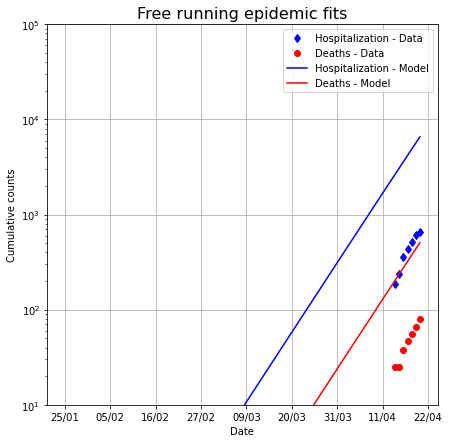

In [12]:
date_form = DateFormatter("%d/%m")

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)


ax.semilogy(ga_date, ga_hosp, 'bd', label = "Hospitalization - Data")
ax.semilogy(ga_date, ga_death, 'ro', label = "Deaths - Data")

ax.semilogy([day_base + datetime.timedelta(days=-int(te) + int(x)) for x in sol_pre.t], \
        stats["Hcum"]* pp.population["N"], 'b-', label = "Hospitalization - Model")

ax.semilogy([day_base + datetime.timedelta(days=-int(te) + int(x)) for x in sol_pre.t], \
        stats["Dcum"]* pp.population["N"], 'r-', label = "Deaths - Model")

ax.set(xlabel = 'Date', ylabel = 'Cumulative counts', ylim = (10e0,10e4))
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
ax.set_xticks(dates)
plt.rc('axes', titlesize = 16)
plt.rc('xtick', labelsize = 12)   
plt.rc('ytick', labelsize = 12)

plt.grid(which = "major")
plt.legend()
plt.title("""Free running epidemic fits""")
plt.show()